In [11]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import time

from scipy.optimize import minimize
from random import choice

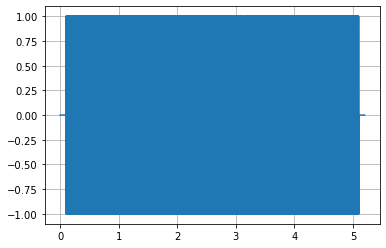

In [12]:
#---------------------------------------------------------------
#signal---------------------------------------------------------
#---------------------------------------------------------------
N = 5000
Ta = 1*10**(-3)

#creating prbs signal
def prbs():
    while True:
        yield choice([False,True])

r = np.zeros(N)
i = 0
for value in prbs():
    r[i] = value
    i = i+1
    if i==N:
        break

r = 2*r-1

r = np.concatenate((np.zeros(100), r, np.zeros(100)))
t = np.linspace(0,(N+200-1)*Ta,N+200)

#t = np.linspace(0,(N-1)*Ta,N)                         
#r = ss.square(2*np.pi*100*t)

plt.figure()
plt.plot(t,r)
plt.grid()
plt.show()


G = TransferFunctionDiscrete(
array([ 0.482 , -0.3856]),
array([ 1.    , -1.84  ,  0.9364]),
dt: 0.001
)


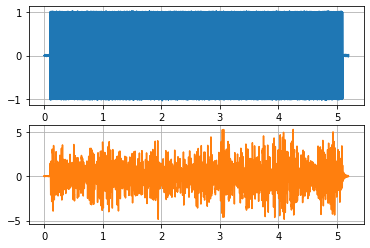

In [13]:
#---------------------------------------------------------------
#plant----------------------------------------------------------
#---------------------------------------------------------------
kg = 2
z1g = 0.8
p1g = 0.92 + 0.3j
p2g = np.conj(p1g)
numG = [1,-z1g]
denG = [1,float(-(p1g+p2g)),float(p1g*p2g)]
evalg = sum(numG)/sum(denG)
numG = np.dot(numG,(1/evalg))
G = ss.TransferFunction(numG,denG,dt=Ta)

print("\nG =",G)

u = r
t,y = ss.dlsim(G,u,t)

nu = 0.1*np.random.normal(0, .1, u.shape)
ny = 0.2*np.random.normal(0, .1, y.shape)

u = u + nu
y = y + ny

fig,axs = plt.subplots(2,1)
axs = axs.reshape(-1)
axs[0].plot(t,u,color='C0')
axs[1].plot(t,y,color='C1')
axs[0].grid()
axs[1].grid()
plt.show()


In [14]:
N = 1000    #size of data
n = 100     #number of Markov parameters

#create Phi and Y matrix
Phi = np.zeros((n,N-n))
for i in range(len(Phi)):
    for j in range(len(Phi[0])):
        Phi[i,j] = u[n+j-i]

Y = np.zeros((N-n,1))
for i in range(len(Y)):
    Y[i,0] = y[n+i]

#initialize variables for hyper-parameter estimation
I = np.identity(N-n)
theta_ls = np.linalg.pinv(Phi @ np.transpose(Phi)) @ Phi @ Y
sig = np.std(theta_ls/2)
c = 0.5
l = 0.5
p = 0.5
P = np.zeros((n,n))

reg = 'CS'    #regularization method

if(reg=='DC'):
    alpha_init = np.array([c,l,p])
elif(reg=='DI' or reg=='TC'):
    alpha_init = np.array([c,l])
elif(reg=='CS'):
    alpha_init = np.array([c])
elif(reg=='none'):
    None
else:
    raise Exception("The chosen regularization method is not valid.")

def Pf(alpha):   
    for k in range(n):
        for j in range(n):
            if(reg=='DC'):
                P[k,j] = alpha[0]*(alpha[2]**abs(k-j))*(alpha[1]**((k+j)/2)) 
            elif(reg=='DI'):
                if(k==j):
                    P[k,j] = alpha[0]*(alpha[1]**k)
                else:
                    P[k,j] = 0
            elif(reg=='TC'):
                P[k,j] = alpha[0]*min(alpha[1]**j,alpha[1]**k)
            elif(reg=='CS'):
                if(k<=j):
                    P[k,j] = alpha[0]*((k**2)/2)*(j-(k/3))
                else:
                    P[k,j] = alpha[0]*((j**2)/2)*(k-(j/3))                    
            elif(reg=='none'):
                None            
    return P

def slogdet(alpha):
    sign,logdet = np.linalg.slogdet(np.transpose(Phi) @ Pf(alpha) @ Phi + (sig**2)*I)
    return logdet

def ML(alpha):
    return (np.transpose(Y) @ np.linalg.pinv((np.transpose(Phi) @ Pf(alpha) @ Phi + (sig**2)*I)) @ Y + slogdet(alpha)).flatten()

if(reg=='DC'):
    bnds = ((0, None), (0, 1), (None,1))
elif(reg=='DI' or reg=='TC'):
    bnds = ((0, None), (0, 1))
elif(reg=='CS'):
    bnds = ((0,None),)
elif(reg=='none'):
    None

if(reg=='none'):
    theta = np.linalg.pinv(Phi @ np.transpose(Phi)) @ Phi @ Y
else:
    start_time = time.time()
    #with bounds, use L-BFGS-B, TNC, SLSQP, Powell, and trust-constr methods
    A = minimize(ML, alpha_init, method='SLSQP', options={'disp': True}, bounds=bnds)
    end_time = time.time()
    alpha = A.x
    theta = Pf(alpha) @ Phi @ np.linalg.pinv((np.transpose(Phi) @ Pf(alpha) @ Phi + (sig**2)*I)) @ Y
    print("\nSolver took {:.2f} seconds to solve minimization with regularization by the Empirical Bayes approach." .format(end_time-start_time))

Optimization terminated successfully    (Exit mode 0)
            Current function value: [-2982.29299598]
            Iterations: 4
            Function evaluations: 49
            Gradient evaluations: 4

Solver took 16.34 seconds to solve minimization with regularization by the Empirical Bayes approach.


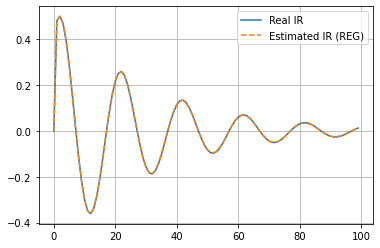

In [15]:
t,G_h = ss.dimpulse(G, n=100)

plt.plot(np.squeeze(G_h),color='C0')
plt.plot(theta,linestyle='--',color='C1')
plt.legend(['Real IR','Estimated IR (REG)','Estimated IR (LS)'])
plt.grid()
plt.show()